<a href="https://colab.research.google.com/github/sseyonafre/Project/blob/main/sprint2/AI_14_%E1%84%80%E1%85%A9%E1%84%89%E1%85%A6%E1%84%92%E1%85%B4_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *DATA SCIENCE / SECTION 2 / PROJECT*

#  🏆 프로젝트 목표
>### kbo 승패예측 모델을 만들고 현재기대순위와 지금 순위를 비교해본다.

## 프로젝트 개요
###1. 문제정의 

>2022년 7월 22일 현재 시즌 전반기가 끝난상황, 모든 팀의 최소목표는 포스트시즌 진출(5위)이다. 
>
>전체 경기의 60%정도 진행된 상황에서 결과를 예측해보고 이에따라 하반기 팀의 전체적인 운용 방향이 크게 달라질 수 있다.
>
>현재 가을야구진출이 불투명한 상황. 확실한 가을야구 진출을 위해서 우리가 어떤 점을 보완할 수 있을 지 알아보려한다.


###2. 프로젝트의 전체적인 순서계획.

> 시즌 순위를 예측하기 위해서 '연'(year)단위 즉, 해당시즌 팀타격기록으로 순위를 예측하면 좋겠지만 데이터의 크기가 너무 작기때문에 매 경기단위로 데이터를 쪼개서 승패여부를 판별한 후, 예측된 승패로 계산된 승률을 토대로 순위 도출.


###3. 타겟정하기

>승리여부 (승리:1, 패:0) -> **분류**
>
>기준모델 : 타겟의 최빈값 -> 0
>
>승리여부와 관계있는 특성은 아무래도 타격은 장타율, 출루율, 투수는 방어율 

###4. 모델링
>로지스틱회귀, 랜덤포레스트,XGBoost, lihgtGBM 모델을 만들어본다.


#  ⚾️ Data Description
* `game_id` : 경기날짜 + 홈팀+ 원정팀 + 더블헤더유무
* `date`: 경기날짜
* `team` : 팀이름
* `vs` : 상대팀
* `home` : 홈경기 여부
* `PA` : 타석수
* `AB `: 타수 (타석에서 희생타, 볼넷, 몸맞는공 등을 제외)
* `RBI`: 타점 (Run Batted In)
* `RUN` : 득점 
* `HIT `: 총 안타수
* `H2`: 2루타
* `H3`: 3루타
* `HR`: 홈런
* `SB`: 도루성공
* `CS`: 도루실패 
* `SF`: 희생플라이
* `BB` : 볼넷
* `HP `: 몸에 맞는 공 ( hit by pitch)
* `K `: 삼진당한 횟수
* `GD`: 더블플레이 (병살당한 횟수)
* `LOB` : 잔루 (left on base)
* `RISP`: 득점권 타율
* `P_AB_CN `: 득점권 상황
* `P_HIT_CN `: 득점권 상황에서의 안타갯수
* `OBP `: 출루율 (on base rate)
* `avg` : 타율 
* `win `: 승리


#  데이터 탐색


## **1. Gathering Data**

In [225]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [226]:
!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import eli5


In [ ]:
#https://www.kaggle.com/datasets/park123/korea-baseball-datasetkbo-20152020
#여기서 2015~2020년까지의 데이터 수집한 후
#2021,22년의 데이터는 캐글에 올려진 깃헙에서 연도만 바꿔서 추가수집. 

In [ ]:
'''
teamN = {}
teamN['한화'] = '한화'
teamN['KIA'] = 'KIA'
teamN['KT'] = 'KT'
teamN['kt'] = 'KT'
teamN['LG'] = 'LG'
teamN['롯데'] = '롯데'
teamN['NC'] = 'NC'
teamN['두산'] = '두산'
teamN['SK'] = 'SK'
teamN['삼성'] = '삼성'
teamN['키움'] = '키움'
teamN['넥센'] = '넥센'
teamN['SSG'] = 'SSG'
for year in [2018]:

    
    #2015~2020 데이터 수집
    urls = []
    for mon in range(3,11): #3월~10월
        urls.extend(getUrlByMonth(year,mon))

    urls = sorted(urls)

    result = []
    for url in tqdm(urls):


        date = url[url.find("date=")+5:url.find("date")+15]
        source = rq.get(url)

        soup = bs(source.text,'lxml')
        tables = soup.findAll("div",{"class":"box"})
        ###팀명
        title1 = tables[2].find("h3",{"class":"box-title"}).text
        try:
            tn1 = title1[title1.index("(")+1:-1]
        except ValueError:
            print("우천")
            continue
        title2 = tables[2].find("h3",{"class":"box-title"}).text
        tn2 = title1[title1.index("(")+1:-1]


        team1 = {}
        try:
            temp = soup.findAll("td",{"bgcolor":"white"})[0]
        except IndexError:
            print("우천")
            continue

        for idx,x in enumerate(temp.findAll("b")):
            team1[x.text] = temp.contents[2::3][idx]

        team1['팀명'] = tn1

        team2 = {}
        temp = soup.findAll("td",{"bgcolor":"white"})[1]
        for idx,x in enumerate(temp.findAll("b")):
            team2[x.text] = temp.contents[2::3][idx]

        team2['팀명'] = tn1

        gujang = parse.unquote([x for x in url.split("&") if 'stadium' in x][0][8:])
        sil1=tables[6].find("table",{"width":"100%"}).contents[1].text
        sil2=tables[7].find("table",{"width":"100%"}).contents[1].text

        team1['날짜'] =  date
        team1['구장'] = gujang
        team1['실책'] = sil1

        team2['날짜'] =  date
        team2['구장'] = gujang
        team2['실책'] = sil2
        result.append([tatu(tables,0),tatu(tables,2),team1,team2])


    
    fin_=[]
    for r in result:

        team1 = r[0]['title'].iloc[0]
        team2 = r[0]['title'].iloc[-1]

        t1 = r[1][r[1]['이름']=='팀 합계'].iloc[0]
        t2 = r[1][r[1]['이름']=='팀 합계'].iloc[-1]



        dic1 = {}
        tn1 = teamN[team1]
        tn2 = teamN[team2]
        dic1['game_id'] = r[2]['날짜'].replace('-','') + tn1+tn2 + '0'
        dic1['date'] = r[2]['날짜'].replace('-','')
        dic1['team'] = tn1
        dic1['vs'] = tn2
        dic1['home'] = 'T'
        dic1['H_p'] = t1['H']
        dic1['R'] = t1['R']
        dic1['ER'] = t1['ER']
        dic1['BB_p'] = t1['BB']
        dic1['K'] = t1['K']
        dic1['HR_p'] = t1['HR']
        dic1['GO-FO'] = t1['GO-FO']
        dic1['ERA'] = t1['ERA']
        dic1['WHIP'] = t1['WHIP']
        fin_.append(dic1)

        dic1 = {}

        dic1['game_id'] = r[2]['날짜'].replace('-','') + tn1+tn2 + '0'
        dic1['date'] = r[2]['날짜'].replace('-','')
        dic1['team'] = tn2
        dic1['vs'] = tn1
        dic1['home'] = 'T'
        dic1['H_p'] = t2['H']
        dic1['R'] = t2['R']
        dic1['ER'] = t2['ER']
        dic1['BB_p'] = t2['BB']
        dic1['K'] = t2['K']
        dic1['HR_p'] = t2['HR']
        dic1['GO-FO'] = t2['GO-FO']
        dic1['ERA'] = t2['ERA']
        dic1['WHIP'] = t2['WHIP']
        fin_.append(dic1)



    df_ = pd.DataFrame(fin_)

    df_ = df_.drop_duplicates().to_csv(f"bb_{year}.csv",index=False) #export

## 투수데이터 크롤링
''' 

'\nteamN = {}\nteamN[\'한화\'] = \'한화\'\nteamN[\'KIA\'] = \'KIA\'\nteamN[\'KT\'] = \'KT\'\nteamN[\'kt\'] = \'KT\'\nteamN[\'LG\'] = \'LG\'\nteamN[\'롯데\'] = \'롯데\'\nteamN[\'NC\'] = \'NC\'\nteamN[\'두산\'] = \'두산\'\nteamN[\'SK\'] = \'SK\'\nteamN[\'삼성\'] = \'삼성\'\nteamN[\'키움\'] = \'키움\'\nteamN[\'넥센\'] = \'넥센\'\nteamN[\'SSG\'] = \'SSG\'\nfor year in [2018]:\n\n    \n    #2015~2020 데이터 수집\n    urls = []\n    for mon in range(3,11): #3월~10월\n        urls.extend(getUrlByMonth(year,mon))\n\n    urls = sorted(urls)\n\n    result = []\n    for url in tqdm(urls):\n\n\n        date = url[url.find("date=")+5:url.find("date")+15]\n        source = rq.get(url)\n\n        soup = bs(source.text,\'lxml\')\n        tables = soup.findAll("div",{"class":"box"})\n        ###팀명\n        title1 = tables[2].find("h3",{"class":"box-title"}).text\n        try:\n            tn1 = title1[title1.index("(")+1:-1]\n        except ValueError:\n            print("우천")\n            continue\n        title2 = tables[2].find("

In [2]:
from google.colab import files
uploaded = files.upload()

Saving baseball.csv to baseball.csv


In [ ]:
#n233a 에서 2015년부터 2022년 까지 데이터를 전부 concat으로 합쳐서 하나의 데이터셋으로 만듦.

In [ ]:
df1 = pd.read_csv('bb_2022.csv')
df1

In [ ]:
df1.columns

In [ ]:
df1.drop(columns=['G_ID','VS_T_ID','TB_SC'],inplace=True)

In [ ]:
df1.rename(columns ={'GDAY_DS':'date','T_ID':'team','R':'R_p','H':'H_p','HR':'HR_p','BB':'BB_p','HBP':'HBP_p','K':'K_p'},inplace=True)

In [ ]:
df1['GO'] = df1['GO-FO'].str.split('-').str[0].astype(int)
df1['FO'] = df1['GO-FO'].str.split('-').str[1].astype(int)
df1['GOFO'] = df1['GO'] / df1['FO'] 
df1

In [ ]:
df1.drop(columns=['GO','FO','GO-FO'],inplace=True)

In [ ]:
df1.head()

## **2. 데이터 탐색 및 정제**

In [79]:
df = pd.read_csv('baseball.csv',index_col=0)

In [80]:
#n233a 에서 컬럼이름도 수정하고, 팀이름도 수정하고 필요없는 컬럼 드랍까지 완료한 데이터셋임.

In [81]:
df.head()

,game_id,date,team,vs,home,PA,AB,RBI,RUN,HIT,...,HP,K,GD,LOB,RISP,P_AB_CN,P_HIT_CN,OBP,avg,win
0,20150328HHNE0,20150328,한화,넥센,T,54.0,42.0,4.0,4.0,10.0,...,1.0,7.0,0.0,24.0,0.133333,15,2,0.352941,0.238095,0.0
1,20150328NEHH0,20150328,넥센,한화,B,46.0,40.0,5.0,5.0,8.0,...,0.0,7.0,1.0,18.0,0.090909,11,1,0.304348,0.200000,1.0
2,20150328KTLT0,20150328,KT,롯데,T,46.0,35.0,8.0,9.0,14.0,...,1.0,8.0,1.0,23.0,0.285714,14,4,0.511111,0.400000,0.0
3,20150328LTKT0,20150328,롯데,KT,B,42.0,37.0,12.0,12.0,14.0,...,1.0,8.0,1.0,17.0,0.437500,16,7,0.439024,0.378378,1.0
4,20150328LGHT0,20150328,LG,KIA,T,34.0,29.0,1.0,1.0,7.0,...,0.0,6.0,2.0,17.0,0.200000,10,2,0.333333,0.241379,0.0


In [82]:
#train :2015~2020 시즌, val: 2021시즌 test:2022상반기.

train = df.query('20150101<date<20210101')
val = df.query('date >20210101')
test = df.query('date >20220101')

In [83]:
train.shape ,val.shape, test.shape

((8656, 27), (2286, 27), (846, 27))

#Feature Engineering

In [84]:
#n233a 에서 game_id를 새로 만듦. 
#원래는 날짜+홈팀+원정팀+더블헤더유무여서, 기아와 삼성의 게임이면 기아기준 row 와 삼성기준row 의 gameid가 같아버림.
#그래서 날짜+팀+상대팀+더블헤더유무 로 바꿈.

In [85]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

TypeError: ignored

In [86]:
pd.options.mode.chained_assignment = None  # default='warn' ,warn 무시.

def eda(df):
    """특성을 엔지니어링 하는 함수입니다."""

    #안타율은 2루타, 3루타 홈런에 대한 가중치가 없으니까 가중치를 줘서 장타율을 만들자.
    #총 밟은 베이스 수로 가중치를 주면 됨. 그래서 hit + h2 + 2*h3 +3*hr /AB 로 구함.
    df['SLG'] = (df['HIT']+ df['H2']+ df['H3']*2 + df['HR']*3) /df['AB']

    #OPS: 출루율과 장타율을 더해줌 -> 공격기여를 한번에 확인할 수 있는 가장 유명한 지표.
    df['OPS']= df['OBP']+df['SLG']
    df['win']=df['win'].replace(0.5,0)       #다중분류가 아닌 이진분류를 위해 무승부를 패로 처리
    df['home']=df['home'].replace({'T':0,'B':1})   
    df.drop(columns=['P_AB_CN','P_HIT_CN','date'],inplace=True)
    for i in ['PA', 'AB', 'RBI', 'RUN',
       'HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SF', 'BB', 'HP', 'K', 'GD', 'LOB','win']:
       df[i]= df[i].astype(int)

    return df

train = eda(train)
val = eda(val)
test = eda(test)    

###데이터 누수방지

feature에 대한 분석을 해보자.

In [88]:
train.columns

Index(['game_id', 'team', 'vs', 'home', 'PA', 'AB', 'RBI', 'RUN', 'HIT', 'H2',
       'H3', 'HR', 'SB', 'CS', 'SF', 'BB', 'HP', 'K', 'GD', 'LOB', 'RISP',
       'OBP', 'avg', 'win', 'SLG', 'OPS'],
      dtype='object')

game_id, date 는 제외하고 나머지 피쳐에 대한 분석을 해보면 
>* 수치형 :
       'PA', 'AB', 'RBI', 'RUN','HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SF', 
       'BB', 'HP', 'K', 'GD', 'LOB','RISP','OBP', 'avg', 'SLG', 'OPS'
>* 명목형 : 
         'vs'
>* 이산형 : 
         'home'
         


In [89]:
numerical_features = ['PA', 'AB', 'RBI', 'RUN','HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SF', 
 'BB', 'HP', 'K', 'GD', 'LOB','RISP','OBP', 'avg', 'SLG', 'OPS']

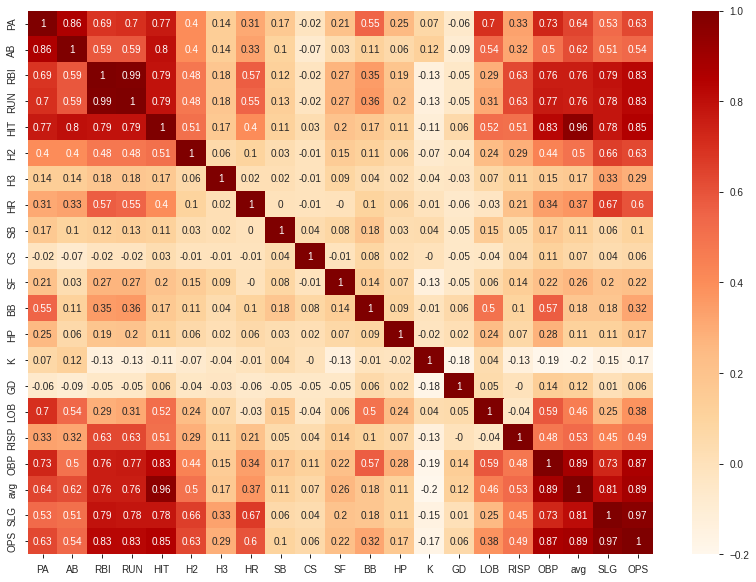

In [90]:
#수치형 변수들의 상관관계.
%matplotlib inline
corr = round(train[numerical_features].corr(),2)
plt.figure(figsize=(14,10))
sns.heatmap(corr,annot=True, cmap='OrRd');

In [91]:
#PA 와 AB는 제외할거니까 생각하지 않아도 됨. 
#타점과 득점은 상관관계가 0.99로 높음. 둘 중 하나는 제거.
#OPS 와 장타율 역시 상관관계가 높음. 

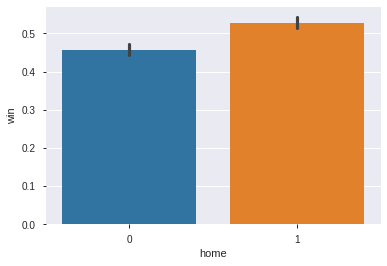

In [92]:
# home 피쳐의 타겟 분포 확인.
sns.barplot(x='home',y='win',data=train);

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45349 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49468 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_

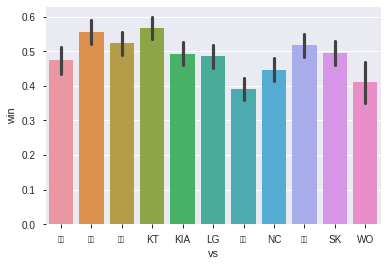

In [93]:
sns.barplot(x='vs',y='win',data=train); #고유값들에 대한 타겟값이 별 차이없음 -> 컬럼삭제.

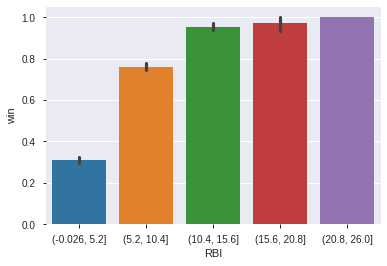

In [94]:
train['RBI'] = pd.cut(train['RBI'], 5)
sns.barplot(x='RBI', y='win', data=train);

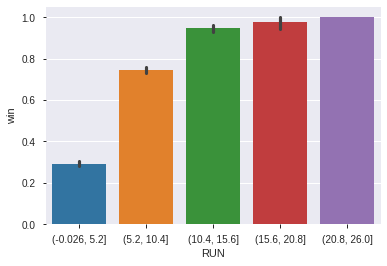

In [95]:
train['RUN'] = pd.cut(train['RUN'], 5)              #RBI 와 RUN 은 상관관계가 높으니 둘 중 하나는 제거!
sns.barplot(x='RUN', y='win', data=train);

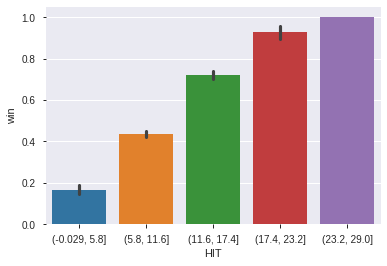

In [96]:
train['HIT'] = pd.cut(train['HIT'], 5)
sns.barplot(x='HIT', y='win', data=train);

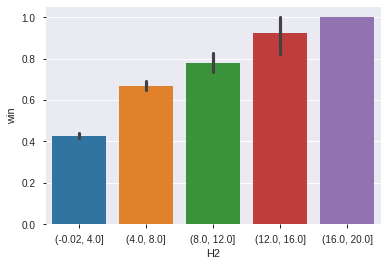

In [97]:
train['H2'] = pd.cut(train['H2'],5)
sns.barplot(x='H2', y='win', data=train);

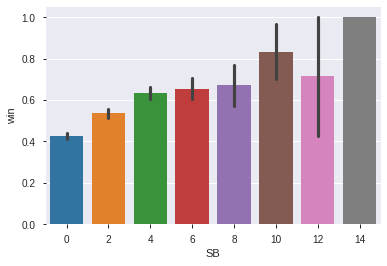

In [98]:
sns.barplot(x='SB',y='win',data=train); #타겟비율의 신뢰구간이 너무 넓음. 통계적 유효성 떨어짐. ->피처로 사용안함.

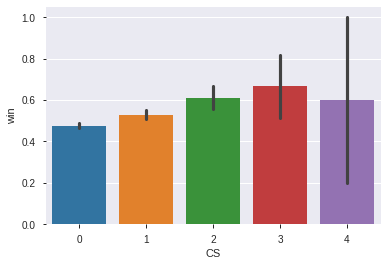

In [99]:
sns.barplot(x='CS',y='win',data=train);   #마찬가지로 제거.

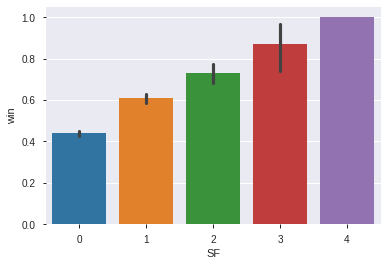

In [100]:
sns.barplot(x='SF',y='win',data=train);

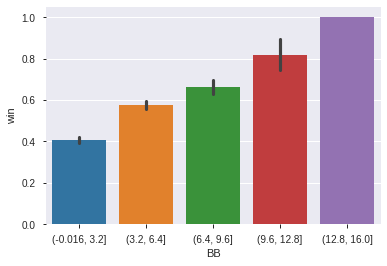

In [101]:
train['BB'] = pd.cut(train['BB'],5)
sns.barplot(x='BB',y='win',data=train);

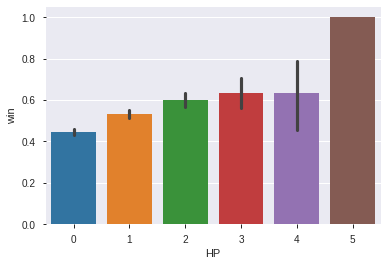

In [102]:
sns.barplot(x='HP',y='win',data=train); #신뢰구간이 넓어서 사용안함.

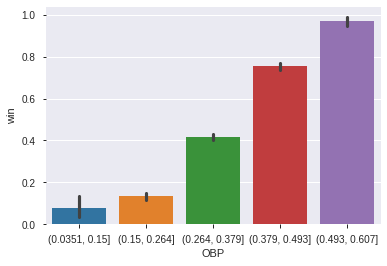

In [103]:
train['OBP'] = pd.cut(train['OBP'], 5)  #OBP,avg,slg,ops,rbi,hit,run 간의 상관관계가 너무 높음....
sns.barplot(x='OBP',y='win',data=train);

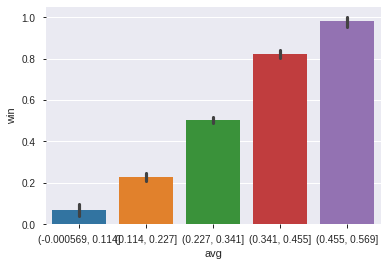

In [104]:
train['avg'] = pd.cut(train['avg'], 5) 
sns.barplot(x='avg',y='win',data=train);

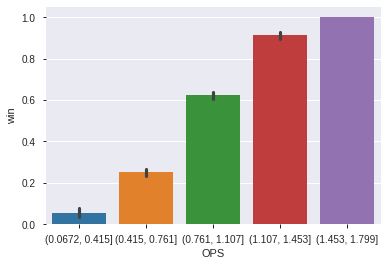

In [105]:
train['OPS'] = pd.cut(train['OPS'], 5) 
sns.barplot(x='OPS',y='win',data=train);

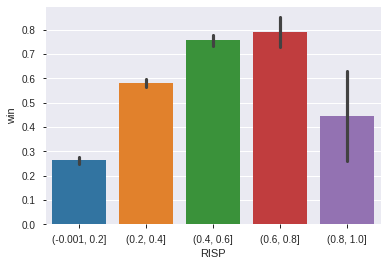

In [106]:
train['RISP'] = pd.cut(train['RISP'], 5)         #구간별 타겟값의 신뢰구간이 넓어서 사용안함.
sns.barplot(x='RISP',y='win',data=train);

In [107]:
# win 과의 상관관계 큰순서.
train.corr().loc['win'].sort_values(ascending=False)

win     1.000000
SLG     0.486945
HR      0.284498
PA      0.260922
SF      0.176544
SB      0.162616
AB      0.132928
HP      0.114651
H3      0.112419
LOB     0.112095
home    0.070942
CS      0.066652
GD     -0.066382
K      -0.189763
Name: win, dtype: float64

In [108]:
#위에서 cut 함수를 이용해서 datatype이 자동으로 카테고리컬로 바뀜. 그래서 다시 바꿔줘야함 
cat_columns = train.select_dtypes(['category']).columns
train[cat_columns] = train[cat_columns].apply(lambda x: x.cat.codes)

#모델링

## **1. 기준모델**

In [109]:
#타겟설정
target = 'win'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.50774
1    0.49226
Name: win, dtype: float64

In [110]:
#기준모델 설정. 
baseline = y_train.mode()
baseline

0    0
dtype: int64

In [111]:
#기준모델의 정확도를 구해보자.
from sklearn.metrics import accuracy_score
y_val = val[target]
y_pred = [baseline] * len(y_val)
print("기준모델 정확도: ", accuracy_score(y_val, y_pred))

기준모델 정확도:  0.5380577427821522


## **2. 로지스틱회귀모델**

In [112]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost.sklearn as xgb
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from eli5.sklearn import PermutationImportance


In [113]:
feature = ['RBI','HR','BB','K', 'GD', 'LOB','RISP','OBP', 'avg', 'SLG', 'OPS', 'home']

In [114]:
X_train = train[feature]
X_val = val[feature]

In [115]:
#로지스틱회귀모델을 만들어 교차검증을 수행. #베이지안최적화를 사용해서 최적의 파라미터 찾아보자.

pipe_lr = make_pipeline(
    StandardScaler(),

    LogisticRegression(n_jobs=-1)
)

k = 3

scores = cross_val_score(pipe_lr, X_train, y_train, cv=k, 
                         scoring='roc_auc')
print(f'auc for {k} folds:', scores)
print(f'교차검증 auc 평균:',scores.mean())

auc for 3 folds: [0.8480364  0.84000529 0.8396414 ]
교차검증 auc 평균: 0.8425610291258244


In [116]:
pipe_lr.fit(X_train,y_train);

In [117]:
y_pred = pipe_lr.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.51      0.88      0.64       707
           1       0.92      0.62      0.74      1579

    accuracy                           0.70      2286
   macro avg       0.71      0.75      0.69      2286
weighted avg       0.79      0.70      0.71      2286



In [118]:
pipe_lr.named_steps['logisticregression'].intercept_

array([0.04753548])

In [119]:
#각 특성의 회귀계수들 
pipe_lr.named_steps['logisticregression'].coef_ 

array([[ 0.46923822, -0.14680001,  0.27417733, -0.28474448, -0.33649471,
        -0.48591161,  0.15618941,  0.5546814 ,  0.17896683,  0.34125802,
         0.38703381,  0.07634778]])

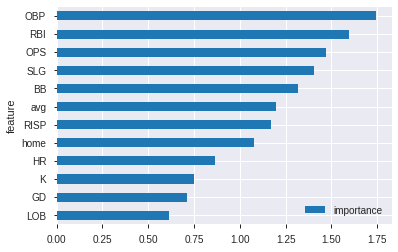

In [120]:
#로지스틱모델 회귀계수를 이용한 특성중요도.
import math
w0 = pipe_lr.named_steps['logisticregression'].intercept_[0]
w =  pipe_lr.named_steps['logisticregression'].coef_[0]

feature_importance = pd.DataFrame(feature, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)
 
from sklearn.linear_model import LogisticRegression
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()  #출루율, 타점, ops, 장타율, 볼넷, 타율, 득점권타율 순

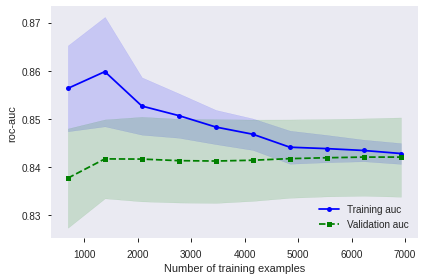

In [121]:
#사이킷런 학습곡선함수 사용해서 모델 성능을 평가.
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, val_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1, scoring='roc_auc')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training auc')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation auc')

plt.fill_between(train_sizes,
                 val_mean + val_std,
                 val_mean - val_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('roc-auc')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

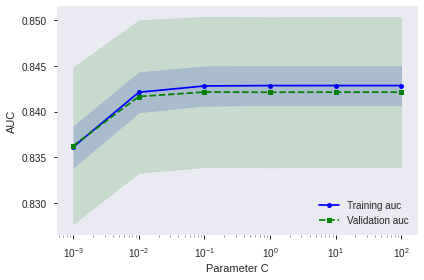

In [122]:
#검증 곡선으로 과대적합과 과소적합 조사
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, val_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=5,scoring='roc_auc')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training auc')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, val_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation auc')

plt.fill_between(param_range, 
                 val_mean + val_std,
                 val_mean - val_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('AUC')
plt.tight_layout()
plt.show()

## **3. 랜덤포레스트모델**

In [123]:
model_rf = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)


k = 3

scores = cross_val_score(model_rf, X_train, y_train, cv=k, 
                         scoring='roc_auc')
print(f'auc for {k} folds:', scores)
print(f'교차검증 auc 평균:',scores.mean())

auc for 3 folds: [0.83573458 0.827802   0.82516488]
교차검증 auc 평균: 0.8295671535898421


In [124]:
model_rf.fit(X_train,y_train);

In [125]:
y_pred = model_rf.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1037
           1       0.73      0.61      0.67      1249

    accuracy                           0.66      2286
   macro avg       0.67      0.67      0.66      2286
weighted avg       0.67      0.66      0.66      2286



In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_val, y_val):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

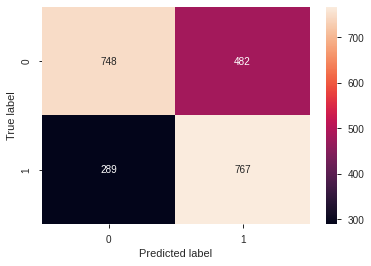

In [127]:
plot_confusion_matrix(model_rf, X_val, y_val) #애초에 모델이 balanced 모델이어서 괜찮은듯!!!

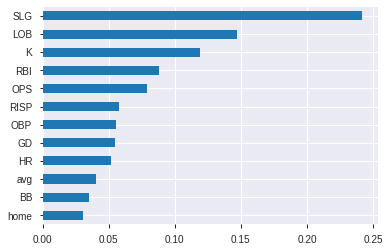

In [128]:
#MDI 특성중요도 .항상 양수값, 각 변수가 split 될 때 불순도 감소분의 평균을 중요도로 정의
importances = pd.Series(model_rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(); #장타율, 잔루, K, 타점, OPS 순으로 로지스틱과 다른양상. 

In [129]:
#Permutation importance 순열중요도


# permuter 정의
permuter_rf = PermutationImportance(
    model_rf, # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_rf.fit(X_val, y_val);

In [130]:
#양수면 양의 상관관계를 나타낸다거나 음수면 음의 상관관계를 나타내는 것이 아님. 그냥 정확도가 가장 변하는 특성
feature_names = X_val.columns.tolist()
pd.Series(permuter_rf.feature_importances_, feature_names).sort_values()

HR     -0.002103
avg     0.000008
OBP     0.000037
home    0.001633
GD      0.003573
K       0.005618
OPS     0.005671
LOB     0.006345
BB      0.006879
RISP    0.007649
RBI     0.030453
SLG     0.092180
dtype: float64

In [131]:
eli5.show_weights(
    permuter_rf, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0922 ± 0.0260,SLG
0.0305 ± 0.0072,RBI
0.0076 ± 0.0030,RISP
0.0069 ± 0.0025,BB
0.0063 ± 0.0100,LOB
0.0057 ± 0.0045,OPS
0.0056 ± 0.0066,K
0.0036 ± 0.0058,GD
0.0016 ± 0.0081,home
0.0000 ± 0.0002,OBP


## **4. xgboost**

In [132]:
#xgboost 는 랜덤포레스트보다 하이퍼파라미터 셋팅에 민감

model_xg = XGBClassifier(random_state=2, n_jobs=-1)

k = 3

scores = cross_val_score(model_xg, X_train, y_train, cv=k, 
                         scoring='roc_auc')
print(f'auc for {k} folds:', scores)
print(f'교차검증 auc 평균:',scores.mean())

auc for 3 folds: [0.8489318  0.84258641 0.84207831]
교차검증 auc 평균: 0.8445321692254436


In [133]:
#xgboost의 교차검증 auc 스코어평균이 제일 높기때문에 xgboost로 모델을 선정한다.

In [172]:
#하이퍼파라미터 선정을 위해서 우선 최적의 max_depth 와 estimators,learning_rate 를 찾는다.
from sklearn.metrics import roc_auc_score

depths = [1,2,3,4,5,6]
for depth in depths:
  xgb = XGBClassifier(max_depth=depth,random_state=2, n_jobs=-1,eval_metric='auc')
  xgb.fit(X_train,y_train)
  y_pred = xgb.predict(X_val)
  roc_auc = roc_auc_score(y_val,y_pred)
  print('max_depth:',depth,'auc:',roc_auc)

#최적의 max_depth = 2

max_depth: 1 auc: 0.6670246674057649
max_depth: 2 auc: 0.6824094604582409
max_depth: 3 auc: 0.6311506836659275
max_depth: 4 auc: 0.6086543791574279
max_depth: 5 auc: 0.6193666851441242
max_depth: 6 auc: 0.5972676459719142


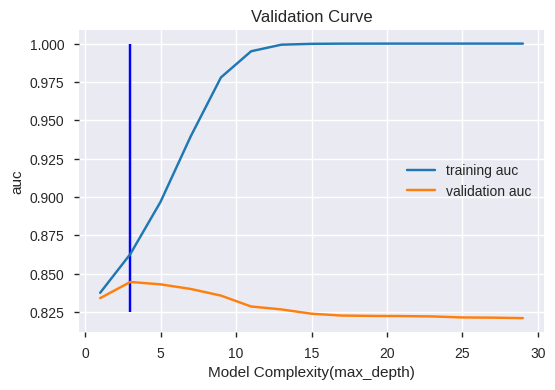

In [205]:
%matplotlib inline
#과적합을 막아줄 때 제한하는 max_depth를 변화시키며 검증곡선을 그려보자

model_xg = XGBClassifier(random_state=2, n_jobs=-1)


depth = range(1, 30, 2)
ts, vs = validation_curve(
    model_xg, X_train, y_train
    , param_name='max_depth'
    , param_range=depth, scoring='roc_auc'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(ts, axis=1)
validation_scores_mean = np.mean(vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training auc')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation auc')

# 이상적인 max_depth
ax.vlines(3,0.825,1, color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='auc')
ax.legend()
fig.dpi = 100

In [ ]:
#교차검증을 통한 검증곡선으로 볼 때는 이상적인 max_depth = 3

In [173]:
estimators = [16,17,18,19,20,21]
for estimator in estimators:
  xgb = XGBClassifier(n_estimators= estimator,max_depth=2,random_state=2, n_jobs=-1,eval_metric='auc')
  xgb.fit(X_train,y_train)
  y_pred = xgb.predict(X_val)
  roc_auc = roc_auc_score(y_val,y_pred)
  print('n_estimators:',estimator,'auc:',roc_auc)
  #최적의 n_estimators = 20

n_estimators: 16 auc: 0.6770417590539541
n_estimators: 17 auc: 0.7182210827790096
n_estimators: 18 auc: 0.7142484294161124
n_estimators: 19 auc: 0.6874191611234295
n_estimators: 20 auc: 0.7190340909090909
n_estimators: 21 auc: 0.7150614375461937


In [177]:
learning_rate_value = [0.001, 0.01, 0.1, 0.15, 0.2, 0.3,0.5, 1]
for value in learning_rate_value:
  xgb = XGBClassifier(learning_rate = value,n_estimators=20, max_depth=2,random_state=2, n_jobs=-1,eval_metric='auc')
  xgb.fit(X_train,y_train)
  y_pred = xgb.predict(X_val)
  roc_auc = roc_auc_score(y_val,y_pred)
  print('learning_rate:',value,'auc:',roc_auc)
  #최적의learning_rate = 0.1

learning_rate: 0.001 auc: 0.5718172579453067
learning_rate: 0.01 auc: 0.5718172579453067
learning_rate: 0.1 auc: 0.7190340909090909
learning_rate: 0.15 auc: 0.6947685698447894
learning_rate: 0.2 auc: 0.6900591278640059
learning_rate: 0.3 auc: 0.6734317257945306
learning_rate: 0.5 auc: 0.619334349593496
learning_rate: 1 auc: 0.6277739283074648


In [195]:
model_xg = XGBClassifier(learning_rate = 0.1,n_estimators=20,max_depth=2,random_state=2, n_jobs=-1)


params = {
    'min_child_weight': [4, 5, 6, 7],
    'gamma': [2,5,7,9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'reg_alpha': [0.4,0.5, 0.6,1],
    'reg_lambda': [0.01, 0.1, 0.5, 1]
    }
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

fit_params={"early_stopping_rounds":50,
                "eval_metric" : "auc", 
                "eval_set" : eval_set
               }

random_search = RandomizedSearchCV(model_xg,cv=5,param_distributions=params,  
                                    scoring='roc_auc',
                                    n_jobs=10,
                                    verbose=10, 
                                     random_state=2,
                                          )

random_search.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-auc:0.792644	validation_1-auc:0.571817
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.802944	validation_1-auc:0.650221
[2]	validation_0-auc:0.812024	validation_1-auc:0.650221
[3]	validation_0-auc:0.812536	validation_1-auc:0.651817
[4]	validation_0-auc:0.812536	validation_1-auc:0.651817
[5]	validation_0-auc:0.812536	validation_1-auc:0.651817
[6]	validation_0-auc:0.82051	validation_1-auc:0.688848
[7]	validation_0-auc:0.820194	validation_1-auc:0.688848
[8]	validation_0-auc:0.820656	validation_1-auc:0.709993
[9]	validation_0-auc:0.82289	validation_1-auc:0.709993
[10]	validation_0-auc:0.823024	validation_1-auc:0.747143
[11]	validation_0-auc:0.825115	validation_1-auc:0.789218
[12]	validation_0-auc:0.824951	validation_1-auc:0.789218
[13]	validation_0-auc:0.824807	validation_1-auc:0.789

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(max_depth=2, n_estimators=20,
                                           n_jobs=-1, random_state=2),
                   n_jobs=10,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7],
                                        'gamma': [2, 5, 7, 9],
                                        'min_child_weight': [4, 5, 6, 7],
                                        'reg_alpha': [0.4, 0.5, 0.6, 1],
                                        'reg_lambda': [0.01, 0.1, 0.5, 1],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=2, scoring='roc_auc', verbose=10)

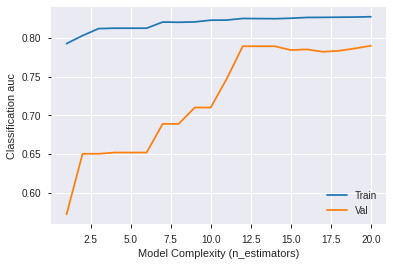

In [196]:
results = random_search.best_estimator_.evals_result()
train_auc = results['validation_0']['auc']
val_auc = results['validation_1']['auc']

epoch = range(1, len(train_auc)+1)
plt.plot(epoch, train_auc, label='Train')
plt.plot(epoch, val_auc, label='Val')
plt.ylabel('Classification auc')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();         

In [197]:
print('테스트 정확도', random_search.score(X_val, y_val))

print(classification_report(y_val, random_search.predict(X_val)))

테스트 정확도 0.7898839769647696
              precision    recall  f1-score   support

           0       0.84      0.49      0.62      1230
           1       0.60      0.89      0.72      1056

    accuracy                           0.68      2286
   macro avg       0.72      0.69      0.67      2286
weighted avg       0.73      0.68      0.66      2286



In [198]:
#최적의 파라미터
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.6, gamma=5, max_depth=2, min_child_weight=7,
              n_estimators=20, n_jobs=-1, random_state=2, reg_alpha=0.5,
              subsample=0.8)

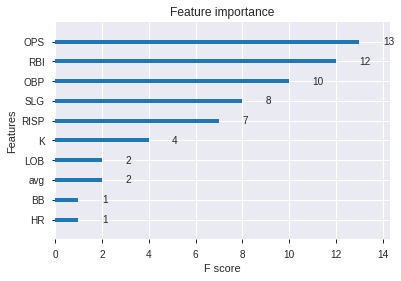

In [199]:
#MDI 특성중요도
from xgboost import plot_importance
plot_importance(random_search.best_estimator_);

In [206]:

#Permutation importance 순열중요도


# permuter 정의
permuter_xgb = PermutationImportance(
    random_search.best_estimator_, # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_xgb.fit(X_val, y_val);

In [207]:
#양수면 양의 상관관계를 나타낸다거나 음수면 음의 상관관계를 나타내는 것이 아님. 그냥 정확도가 가장 변하는 특성
feature_names = X_val.columns.tolist()
pd.Series(permuter_xgb.feature_importances_, feature_names).sort_values()

GD      0.000000
LOB     0.000000
OBP     0.000000
avg     0.000000
home    0.000000
HR      0.000349
OPS     0.000935
BB      0.001465
K       0.009228
RISP    0.027177
RBI     0.077640
SLG     0.107108
dtype: float64

In [208]:
eli5.show_weights(
    permuter_xgb, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1071 ± 0.0189,SLG
0.0776 ± 0.0171,RBI
0.0272 ± 0.0053,RISP
0.0092 ± 0.0061,K
0.0015 ± 0.0010,BB
0.0009 ± 0.0016,OPS
0.0003 ± 0.0037,HR
0 ± 0.0000,home
0 ± 0.0000,avg
0 ± 0.0000,OBP


In [ ]:
pdp